# Beamline 8.3.2 Reconstruction

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
import os
import multiprocessing as mp
os.environ['NUMEXPR_MAX_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
os.environ['TOMOPY_PYTHON_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
import time
import numexpr
import numpy as np
from skimage import transform, filters, io
import tomopy
import svmbir
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from pathlib import Path
from ipywidgets import interact, fixed, FloatSlider, IntSlider
import ALS_recon_functions as als
import ALS_recon_helper as helper
import copy
import pandas as pd
import base64
import pickle
from ipyfilechooser import FileChooser



use_gpu = als.check_for_gpu()
layout = widgets.Layout(width='auto', height='40px')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Choose Data

In [4]:
dataDir = "/global/cfs/cdirs/als/users/tomography_notebooks/example_data" # where is the raw data
file_chooser = FileChooser(dataDir)
file_chooser.filter_pattern = '*.h5' # only show .h5 files
file_chooser.title = f'Choose data file'
display(file_chooser)

FileChooser(path='/global/cfs/cdirs/als/users/tomography_notebooks/example_data', filename='', title='Choose d…

## Find Center of Rotation (COR)
##### Check COR by manually aligning 0 and 180 degree projections
Note: not doing anything with y shift at the moment (could use as constant rotation about ray-axis )

20190501_120317_projectCocoon.h5:
numslices: 2160, rays: 2560, numangles: 1313
angularrange: 180.0, \pxsize: 0.641 um, distance: 0 mm. energy: 0.0 keV


Output()

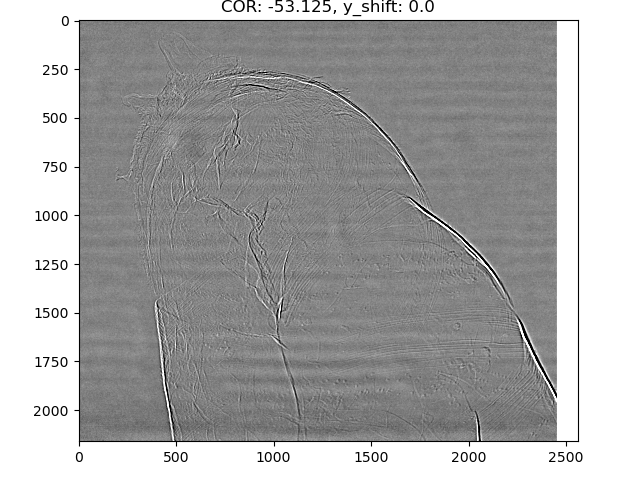

In [35]:
if file_chooser.selected is None:
    print("No datafile selected. Click Select to choose a datafile")
    sys.exit()
metadata = als.read_metadata(file_chooser.selected, print_flag = True)
tomo, _ = als.read_data(file_chooser.selected, proj=slice(0,None,metadata['numangles']-1), downsample_factor=None, prelog=True)
cor_init = als.auto_find_cor(file_chooser.selected) # cross-correlation based COR estimate
first_proj, last_proj_flipped = tomo[0], np.fliplr(tomo[-1])

axs, img, cor_sliders, cor_out = als.plot_0_and_180_proj_diff(first_proj,
                                                              last_proj_flipped,
                                                              init_cor=-2*cor_init,
                                                              # yshift=True,
                                                              fignum=0)
                                                            
display(cor_sliders,cor_out)

## Run Following Cell to Choose Reconstruction Parameters
##### see below for parameter descriptions

Box(children=(VBox(children=(Label(value='Official Recon', layout=Layout(justify_content='center')), Dropdown(…

Output()

Output()

interactive(children=(FloatRangeSlider(value=(-0.0017479825229384006, 0.001768380384892223), description='Colo…

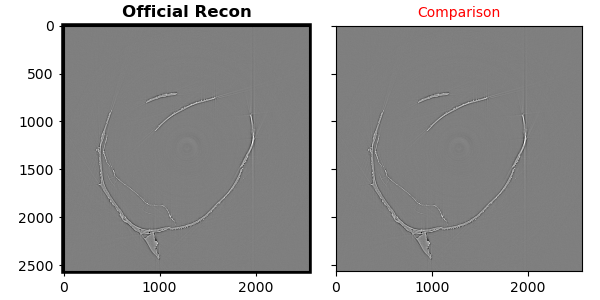

interactive(children=(IntSlider(value=0, description='Projection', layout=Layout(width='50%'), max=1312), Outp…

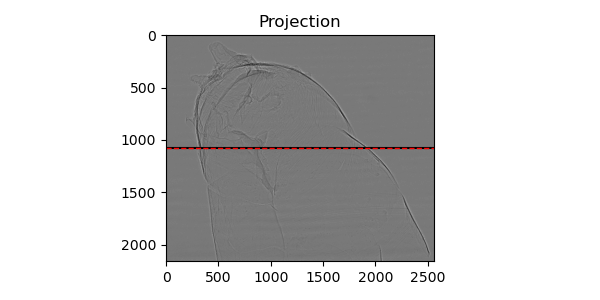

In [36]:
plt.ioff() # turn off matplotlib interactive mode -- plots wont immediately display, so can control order better
# Initial recon needed to get size/colorscale of plots
tomo, angles = als.read_data(file_chooser.selected,
                             proj=slice(0,-1,8),
                             sino=slice(metadata["numslices"]//2,metadata["numslices"]//2+1,1),
                             downsample_factor=1)
cor = -cor_sliders.children[0].value/2
recon_init = als.astra_fbp_recon(tomo, angles, COR=cor, fc=1, gpu=use_gpu).squeeze()
clim_init = [np.percentile(recon_init,1),np.percentile(recon_init,99)]

# Reconstructions figures
if plt.fignum_exists(1): plt.close(1)
recon_comparison_fig, recon_comparison_axs = plt.subplots(1,2,num=1,figsize=(6,3),sharex=True,sharey=True)
recon_comparison_img = [None, None]
recon_comparison_img[0] = recon_comparison_axs[0].imshow(recon_init,cmap='gray')
recon_comparison_axs[0].set_title('Official Recon',fontweight="bold")
recon_comparison_axs[0].patch.set_edgecolor('black')  
recon_comparison_axs[0].patch.set_linewidth(4)  
recon_comparison_img[1] = recon_comparison_axs[1].imshow(recon_init,cmap='gray')
recon_comparison_axs[1].set_title('Comparison',color='r', fontsize=10)
plt.tight_layout()

# Projections figures
if plt.fignum_exists(2): plt.close(2)
proj_fig, proj_axs = plt.subplots(1,1,num=2,figsize=(6,3),sharex=True,sharey=True)
proj_img = proj_axs.imshow(first_proj,cmap='gray')
hline_handles = [None, None]
hline_handles[0] = proj_axs.axhline(y=0,color='k',linestyle='-')
hline_handles[1] = proj_axs.axhline(y=0,color='r',linestyle='--',linewidth=1)
proj_axs.set_title('Projection')
plt.tight_layout()

recon_widgets_dict, out1 = helper.reconstruction_parameter_options(file_chooser.selected,metadata,cor,use_gpu,recon_comparison_img[0],hline_handles[0],'Official Recon')
comparison_widgets_dict, out2 = helper.reconstruction_parameter_options(file_chooser.selected,metadata,cor,use_gpu,recon_comparison_img[1],hline_handles[1],'Comparison')

clim_slider = widgets.interactive(als.set_clim, img=widgets.fixed(recon_comparison_img),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=recon_init.min(), max=recon_init.max(),
                                                                   step=(recon_init.max()-recon_init.min())/500, value=clim_init,
                                                                   readout=True, readout_format='.2e')
                                 )
proj_slider = widgets.interactive(als.set_proj, path=widgets.fixed(file_chooser.selected), img=widgets.fixed(proj_img),
                              proj_num=widgets.IntSlider(description='Projection', layout=widgets.Layout(width='50%'),
                                                                   min=0, max=metadata["numangles"]-1,
                                                                   step=1, value=0)
                                 )

# Haven't played around with layout too much. This part could probably be much fancier
box_layout = widgets.Layout(width='100%',
                            height='auto'
                           )
box = widgets.Box(children=[widgets.VBox(list(recon_widgets_dict.values())),
                            widgets.VBox(list(comparison_widgets_dict.values()))],
                  layout=box_layout)

# Display
display(box, out1, out2) # show recon parameter widgets
display(clim_slider) # show color scale widget
recon_comparison_fig.show() # show recon figure
display(proj_slider) # show projection widget
proj_fig.show() # show projection figure
plt.ion() # turn matplotlib interactive mode back on

### Parameter Descriptions

#### 1. Alignment
* **COR:**
Initializes to value found above, but can fine tune if desred. With mismatched COR, arc/shadow artifacts appear in image. Adjust COR to minimize artifacts.

#### 2. Resolution
*Note: On NERSC, reconstruction takes ~2-4 sec/slice with GPU, ~30 sec/slice on CPU at full resolution (1313 ang x 2560 rays).*

* **Angle Downsampling:**
Downsampling angles by 2x reduces reconstruction time by ~2x, but may introduce streaks through center.

* **Projection Downsampling:**
Downsampling projections by 2x reduces spatial resolution by 2x, reconstruction time by ~4x (minus loading time).

#### 3. Ring Removal
*Note: strong stripe removal takes time, can reduce resolution and sometimes even introduce artifacts too, so only use as much as you need to remove visible rings

* **Small Ring Size:**
Window size of the median filter to remove small stripes. Larger is stronger but takes longer. Set to appx width of small stripes. Always choose odd value, set to 1 to turn off.

* **Large Ring Size:**
Window size of the median filter to remove large stripes. Set to appx width of large stripes -- should be larger value than Small Ring Size. Always choose odd value, set to 1 to turn off.

* **Ring Removal SNR:**
Sensitivity of large stripe detection method. Smaller is more sensitive. No affect on small stripes. Recommended values: 1.1 -- 3.0.

### Set Final Reconstruction Settings

In [37]:
save_file_chooser = FileChooser(als.get_scratch_path())
save_file_chooser.show_only_dirs = True
save_file_chooser.title = f'Choose where to save reconstruction'

slices_header_widget = widgets.Label(value="Choose which slices to reconstruct",layout=widgets.Layout(justify_content="center"))

start_slice_widget = widgets.BoundedIntText(description='Start Slice',
                                min=0,
                                max=metadata['numslices']-1,
                                step=1,
                                value=0,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
stop_slice_widget = widgets.BoundedIntText(description='Stop Slice',
                                min=0,
                                max=metadata['numslices']-1,
                                step=1,
                                value=metadata['numslices']-1,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
slices_box = widgets.VBox([slices_header_widget,start_slice_widget,stop_slice_widget])
display(save_file_chooser)
display(slices_box)

FileChooser(path='/pscratch/sd/d/dperl', filename='', title='Choose where to save reconstruction', show_hidden…

In [63]:
data_settings = {
   "output_path": save_file_chooser.selected_path, # existing folder where you can write lots of data
   "data_path": file_chooser.selected, # don't change
   "name": os.path.splitext(file_chooser.selected_filename)[0], # don't change
   "start_slice": start_slice_widget.value,
   "stop_slice": stop_slice_widget.value,
   "angles_ind": slice(0,-1,recon_widgets_dict['angle_downsample'].value), # use every angle 
   "proj_downsample": recon_widgets_dict['proj_downsample'].value,
}

preprocess_settings = {
   "minimum_transmission": recon_widgets_dict['min_transmission'].value,
   "snr": recon_widgets_dict['snr'].value, 
   "la_size": recon_widgets_dict['large_size'].value,
   "sm_size": recon_widgets_dict['small_size'].value,
}

recon_settings = {
   "COR": recon_widgets_dict['cor'].value/recon_widgets_dict["proj_downsample"].value, # important to divide by projection downsampling factor
   "fc": recon_widgets_dict['fc'].value, 
   "use_gpu": use_gpu
}

settings = {"data": data_settings, "preprocess": preprocess_settings, "recon": recon_settings}
for subset in settings:
   print('\n' + subset.upper())
   for key in settings[subset]:
       print(f"{key}: {settings[subset][key]}")


DATA
output_path: /pscratch/sd/d/dperl/tomo_data/test
data_path: /global/cfs/cdirs/als/users/tomography_notebooks/example_data/20190501_120317_projectCocoon.h5
name: 20190501_120317_projectCocoon
start_slice: 1000
stop_slice: 1159
angles_ind: slice(0, -1, 1)
proj_downsample: 1

PREPROCESS
minimum_transmission: 0.0
snr: 3
la_size: 1
sm_size: 11

RECON
COR: -53.125
fc: 1.0
use_gpu: True


## Reconstruct 3D Volume

### Reconstruct and save in notebook
##### *Note: For more efficient workflow, submit reconstruction to NERSC batch job (see below)*

In [39]:
nchunk = 50 # Balance between available cpus and memory (larger value can be more parallelized but uses more memory). 50 was empirically chosen on Perlmutter exclusive node, though 100 was more or less the same.
save_dir = os.path.join(settings["data"]["output_path"],settings["data"]["name"])
if not os.path.exists(save_dir): os.makedirs(save_dir)
save_name = os.path.join(save_dir,"img")
for i in range(np.ceil((settings["data"]['stop_slice']-settings["data"]['start_slice'])/nchunk).astype(int)):
    start_iter = settings["data"]['start_slice']+i*nchunk
    stop_iter = np.minimum(start_iter+nchunk,settings["data"]['stop_slice'])
    print(f"Starting recon of slices {start_iter}-{stop_iter}...",end=' ')
    tic = time.time()

    recon = helper.default_reconstruction(path=settings["data"]["data_path"],
                           angles_ind=settings["data"]['angles_ind'],
                           slices_ind=slice(start_iter,stop_iter,1),
                           proj_downsample=settings["data"]["proj_downsample"],
                           COR=settings["recon"]["COR"],
                           fc=settings["recon"]["fc"],
                           preprocessing_args=settings["preprocess"],
                           use_gpu=settings["recon"]["use_gpu"])

    print(f"Finished: took {time.time()-tic} sec. Saving files...")
    dxchange.write_tiff_stack(recon, fname=save_name, start=start_iter)
print("Done")

Starting recon of slices 1000-1050... Finished: took 11.523780584335327 sec. Saving files...
Starting recon of slices 1050-1100... Finished: took 10.23720097541809 sec. Saving files...
Starting recon of slices 1100-1150... Finished: took 11.62425971031189 sec. Saving files...
Starting recon of slices 1150-1159... Finished: took 7.408404111862183 sec. Saving files...
Done


### Reconstruct and save with NERSC batch job
##### 1. The cell below prepares the config script needed to submit a job

In [66]:
import batch_run

with open (als.get_batch_template(), "r") as t:
    template = t.read()
    
configs_dir = Path(os.path.join(settings["data"]["output_path"],"configs/"))
if not configs_dir.exists():
    os.mkdir(configs_dir)

config_script_name = os.path.join(configs_dir,"config_"+settings["data"]["name"]+".sh")    
enc = batch_run.dictionary_prep(settings)
with open(config_script_name, 'w') as f:
    script = template
    script += "\n"
    script += "cd " + os.getcwd()
    script += "\n"
    script += "python batch_run.py"
    script += " '" + enc + "'"
    f.write(script)
    f.close()
    
# list configsDir
print(f"Contents of batch jobs configs directory: {configs_dir}") 
os.system(f"ls {configs_dir}")
print('')

Contents of batch jobs configs directory: /pscratch/sd/d/dperl/tomo_data/test/configs
config_20190501_120317_projectCocoon.sh



##### 2. Run the following cell to submit the batch job

In [67]:
# submit batch job config you just created
os.system(f"sbatch {os.path.join(configs_dir,config_script_name)}")
# see all current batch jobs (including this interavtive jupyter session)
print("List of current batch jobs:")
os.system("sqs")

Submitted batch job 2800576
List of current batch jobs:
JOBID            ST USER      NAME          NODES TIME_LIMIT       TIME  SUBMIT_TIME          QOS             START_TIME           FEATURES       NODELIST(REASON
2800576          PD dperl     tomo832       1          30:00       0:00  2022-07-25T13:47:35  gpu_regular     N/A                  gpu            (Priority)     
2800331_[130,140 PD dperl     predict_xsec  1          30:00       0:00  2022-07-25T13:07:06  gpu_regular     N/A                  gpu            (JobArrayTaskLi
2799717          R  dperl     jupyter       1        6:00:00    2:54:09  2022-07-25T10:50:20  gpu_jupyter     2022-07-25T10:53:27  gpu            nid003917      
2800331_120      R  dperl     predict_xsec  1          30:00       1:35  2022-07-25T13:07:06  gpu_regular     2022-07-25T13:46:01  gpu            nid003628      
2800331_110      R  dperl     predict_xsec  1          30:00       2:41  2022-07-25T13:07:06  gpu_regular     2022-07-25T13:44:55  gpu

0

##### To cancel a batch job, run this cell with the right Job ID

In [ ]:
# eq. scancel 2800193
os.system("scancel 0000000")

### Alternatively, you can submit all job scripts in a folder using helper bash script
##### 1. Modify first line of submit_all_jobs_template.sh with your configs directory (from cell below)
##### 2. Save as new bash script (eg. my_submit_all_jobs.sh)
##### 3. In terminal, `source [bash script name]`

In [62]:
#Please use this to change out the filepath in the 
#bash script (the helper script to loop and submit all configs).
print(str(configs_dir.absolute())+"/*")

/pscratch/sd/d/dperl/tomo_data/test/configs/*


### Optional: SVMBIR reconstruction (for better image quality)
##### Note: SVMBIR is MUCH slower. At full resolution (1313 ang x 2560 rays), takes ~2-4 min/slice with all 128 exclusive node threads (uses CPU only). Downsampling by 2x reduces time by ~4x (plus loading time)

In [ ]:
%%time
"""
########## PARAMETERS ##########

# Default settings are typically good, don't necessarily need to change

### p ###
smoothing parameter for large grayscale differences (ie contrasting pixels). Between 1 and 2 (1 = total variation regularization, 2 = Tikhonov regularization)

### q ###
# smoothing parameter for small grayscale differences (ie. similar pixels). Between p and 2

### T ###
# transition value from q to p (in pixel grayscale difference). Must be > 0

### sharpness ###
# stregth of smoothing -- lower is more smooth. +1 change is equivalent to +6 dB snr. Can typically just change one or the other

### snr_dB ###
# strength of smoothing -- lower is more smooth. +6 dB is equivalent to +1 sharpness. Can typically just change one or the other
"""
p = 1.2 
q = 2 
T = 0.1 
sharpness = 0 
snr_dB = 40.0 
########## dont touch code below ##########

svmbir_settings = {
    "p": p, 
    "q": q, 
    "T": T,
    "sharpness": sharpness, 
    "snr_dB": snr_dB,
    "max_iter": 100,
    "COR": process_settings['COR']/process_settings['downsample_factor'],
    "init_image": preprocess_recon
}

tomo, angles = als.read_data(settings["path"], sino=settings["slices_ind"], downsample_factor=settings["downsample_factor"],args=process_settings)
svmbir_recon = als.svmbir_recon(tomo,angles,**svmbir_settings)
print(f"Finisehd reconstruction, size: {fbp_recon.shape}")
print('')
print('This took:')

In [ ]:
img, axs, clim_slider = als.plot_recon_comparison(preprocess_recon, svmbir_recon, titles=['FBP','SVMBIR'], fignum=5, figsize=4)
display(clim_slider)